# Libs

In [1]:
%matplotlib inline

import os

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage
import os
import seaborn as sns

import cv2

import sys
sys.path.append('../scripts/')

from Annotation_functions import draw_annotations, get_boxes, get_filtered_bboxes, morph_op

# Checking the idea of segmentation by Hue

loading image

In [2]:
bacteria = cv2.imread('../pictures/test_input_5.bmp')

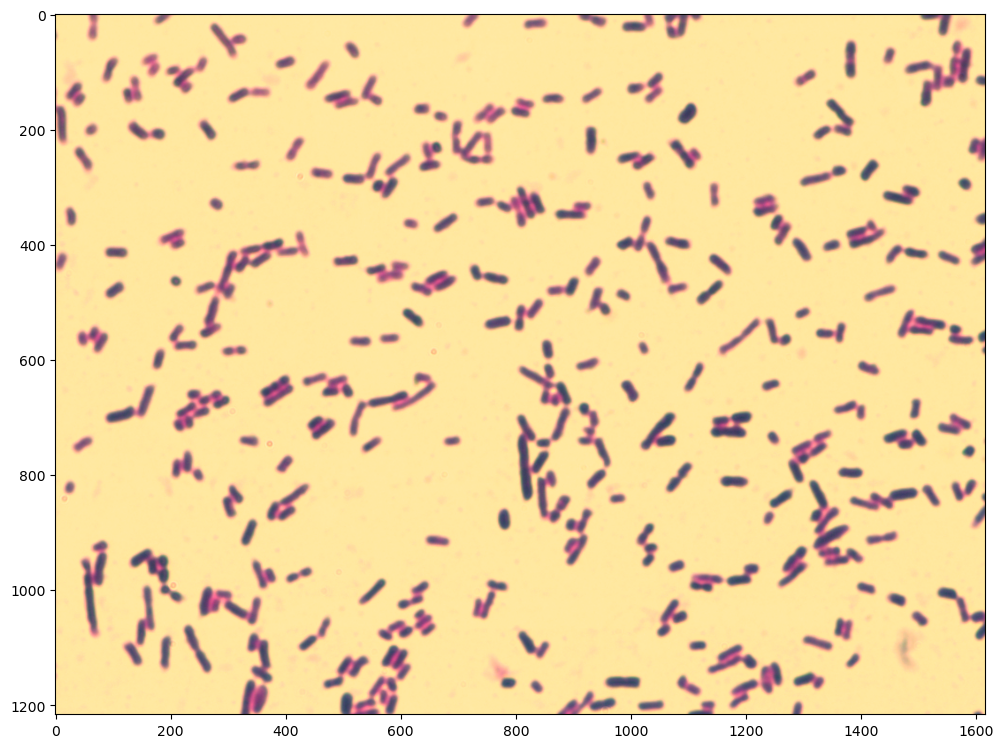

In [3]:
plt.figure(figsize = (12,10))
plt.imshow(bacteria[:,:,::-1])
plt.show()

In [4]:
bacteria.shape

(1216, 1616, 3)

filtering image (by downscaling and upscaling)

In [5]:
bacteria_filtered = cv2.resize(np.uint8(skimage.measure.block_reduce(bacteria, (2,2,1), np.mean, func_kwargs={'dtype': np.float16})),
                                bacteria.shape[1::-1], interpolation = cv2.INTER_CUBIC)

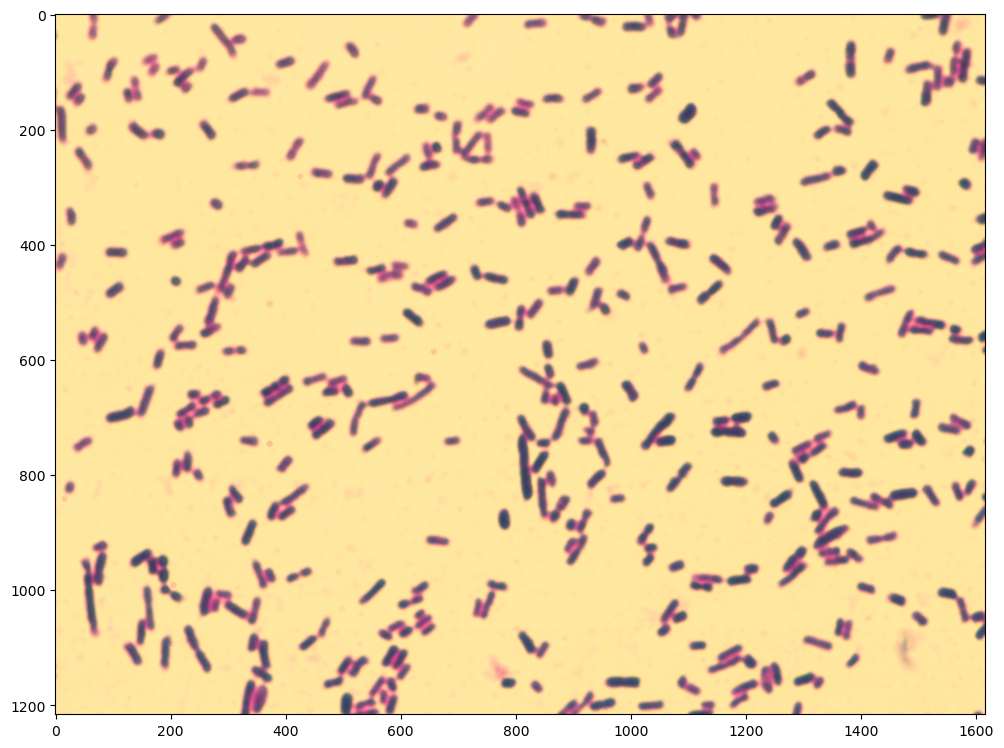

In [6]:
plt.figure(figsize = (12,10))
plt.imshow(bacteria_filtered[:,:,::-1])
plt.show()

Hue inspection

In [7]:
bacteria_filtered_hsv = cv2.cvtColor(bacteria_filtered, cv2.COLOR_BGR2HSV)

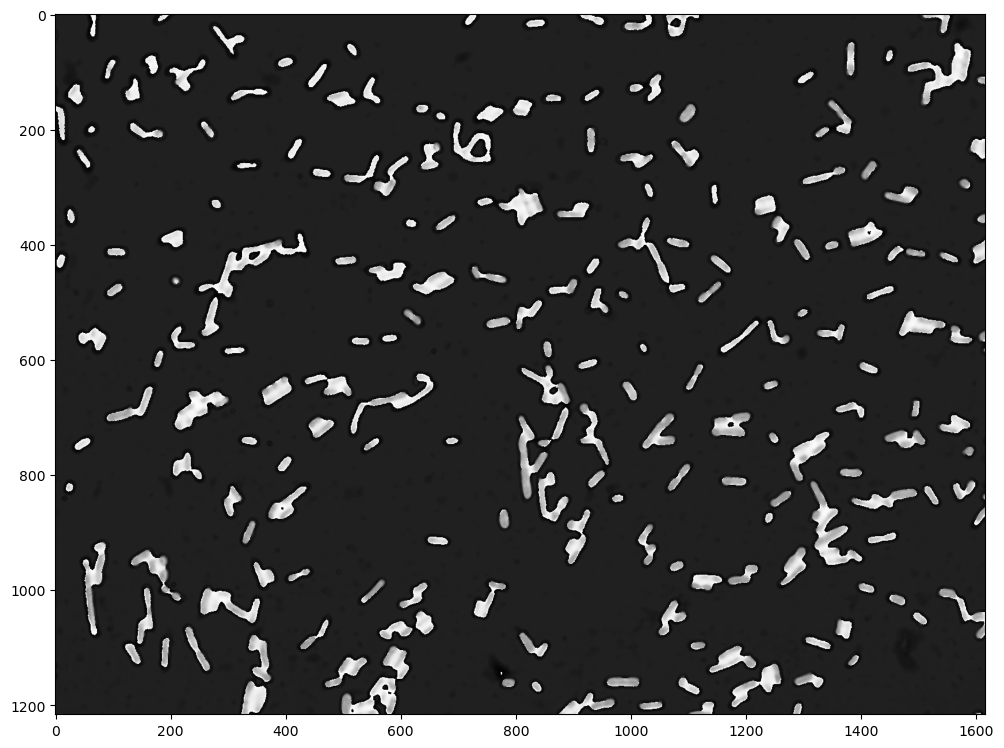

In [8]:
plt.figure(figsize = (12,10))
plt.imshow(bacteria_filtered_hsv[:,:,0], cmap = 'gray')
plt.show()

In [9]:
bacteria_filtered_hsv_histogram = np.histogram(bacteria_filtered_hsv[:,:,0].flatten(), bins=[el for el in range(181)])

In [10]:
bacteria_filtered_hsv_histogram[1][np.argmax(bacteria_filtered_hsv_histogram[0])]

23

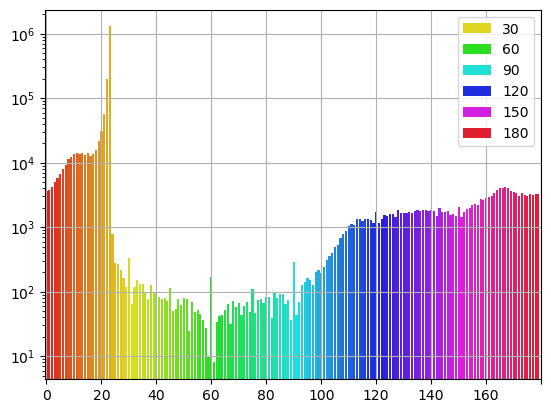

In [11]:
sns.barplot(x = bacteria_filtered_hsv_histogram[1][0:-1], y = bacteria_filtered_hsv_histogram[0], hue = bacteria_filtered_hsv_histogram[1][1:], palette='hsv')
plt.yscale('log')
plt.xticks(np.arange(0,181,20))
plt.grid()
plt.show()

Thresholding by hue

In [12]:
threshold_value, bacteria_filtered_hsv_thresholded = cv2.threshold(bacteria_filtered_hsv[:,:,0],60,180,cv2.THRESH_TOZERO)

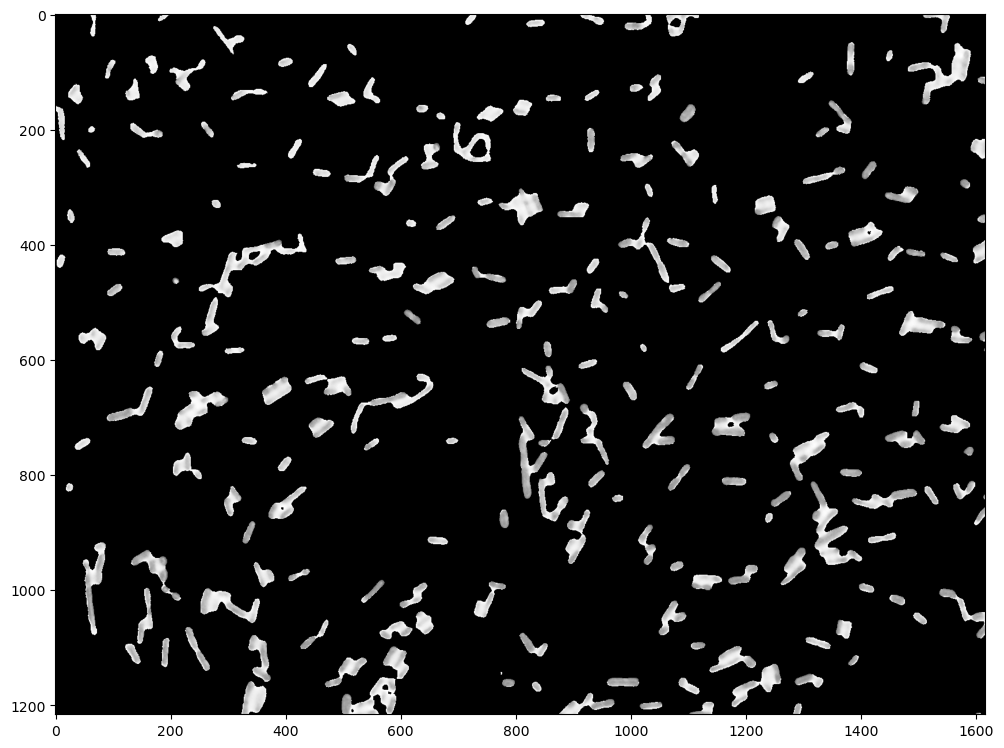

In [13]:
plt.figure(figsize = (12,10))
plt.imshow(bacteria_filtered_hsv_thresholded, cmap='gray')
plt.show()

Drawing contours on image

In [14]:
cv2.findContours(cv2.threshold(bacteria_filtered_hsv[:,:,0],80,180,cv2.THRESH_BINARY)[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

((array([[[1602, 1214]],
  
         [[1601, 1215]],
  
         [[1608, 1215]],
  
         [[1607, 1214]]], dtype=int32),
  array([[[1291, 1197]],
  
         [[1289, 1199]],
  
         [[1288, 1199]],
  
         [[1287, 1200]],
  
         [[1287, 1201]],
  
         [[1286, 1202]],
  
         [[1286, 1203]],
  
         [[1285, 1204]],
  
         [[1285, 1208]],
  
         [[1284, 1209]],
  
         [[1284, 1212]],
  
         [[1283, 1213]],
  
         [[1283, 1215]],
  
         [[1294, 1215]],
  
         [[1294, 1214]],
  
         [[1295, 1213]],
  
         [[1295, 1210]],
  
         [[1296, 1209]],
  
         [[1296, 1206]],
  
         [[1297, 1205]],
  
         [[1297, 1203]],
  
         [[1296, 1202]],
  
         [[1296, 1199]],
  
         [[1295, 1198]],
  
         [[1292, 1198]]], dtype=int32),
  array([[[1131, 1195]],
  
         [[1130, 1196]],
  
         [[1129, 1196]],
  
         [[1128, 1197]],
  
         [[1127, 1197]],
  
         [[1127, 1198]],

In [15]:
bacteria_filtered_contours = sorted(cv2.findContours(cv2.threshold(bacteria_filtered_hsv[:,:,0],80,180,cv2.THRESH_BINARY)[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key = cv2.contourArea, reverse= True)
bacteria_filtered_contours_drawn = bacteria_filtered.copy()
bacteria_filtered_contours_drawn = cv2.drawContours(bacteria_filtered_contours_drawn,
                                                     bacteria_filtered_contours,
                                                     contourIdx=-1, color=(0, 255, 0), thickness=2)

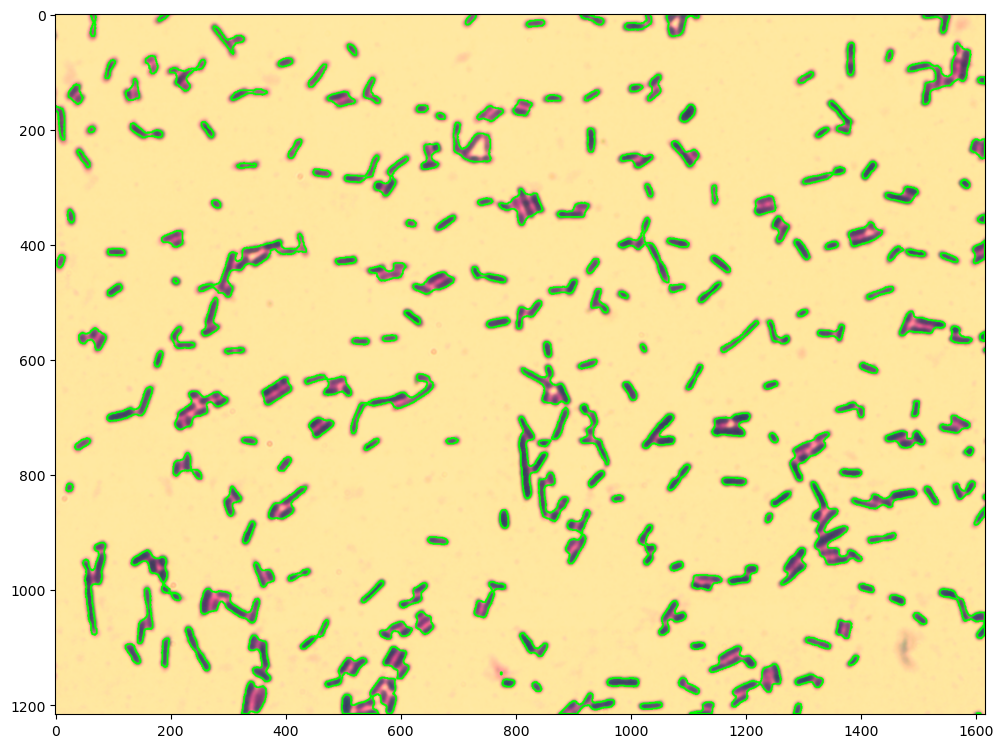

In [16]:
plt.figure(figsize = (12,10))
plt.imshow(bacteria_filtered_contours_drawn[:,:,::-1])
plt.show()

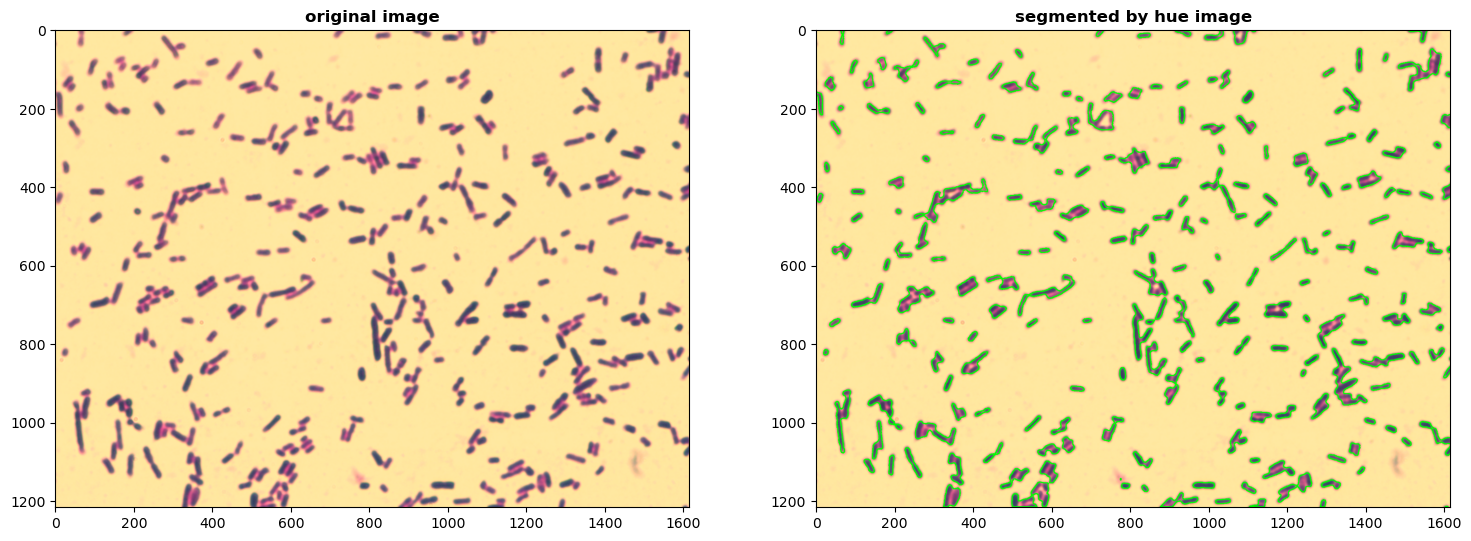

In [17]:
fig, axs = plt.subplots(1,2,figsize=(18,12))
axs[0].imshow(bacteria_filtered[:,:,::-1])
axs[0].set_title('original image', weight='bold')

axs[1].imshow(bacteria_filtered_contours_drawn[:,:,::-1])
axs[1].set_title('segmented by hue image', weight='bold')

plt.show()

# Extracting segmented regions from image for further analysis

In [18]:
len(bacteria_filtered_contours)

218

In [19]:
bacteria_filtered_contours[42].shape

(90, 1, 2)

In [20]:
x, y, w, h = cv2.boundingRect(sorted(bacteria_filtered_contours, key=np.shape, reverse=True)[0])
x, y, w, h

(250, 381, 187, 111)

In [21]:
# x = x - 5
# y = y - 5
# w = w + 10
# h = h + 10

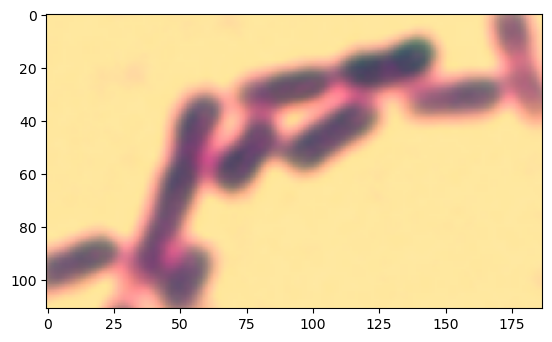

In [22]:
plt.figure()
plt.imshow(bacteria_filtered[y:y + h, x:x + w,::-1])
plt.show()

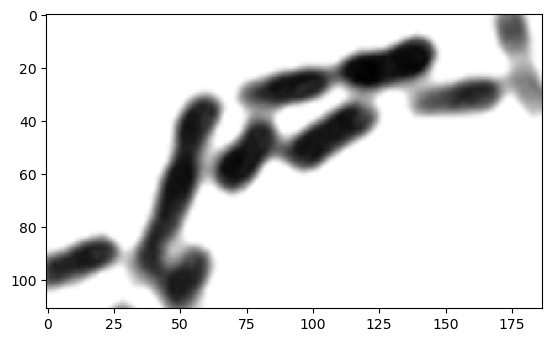

In [23]:
plt.figure()
# plt.imshow(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),cmap='gray', vmin=0)
plt.imshow(bacteria_filtered_hsv[y:y + h, x:x + w,2],cmap='gray')
plt.show()

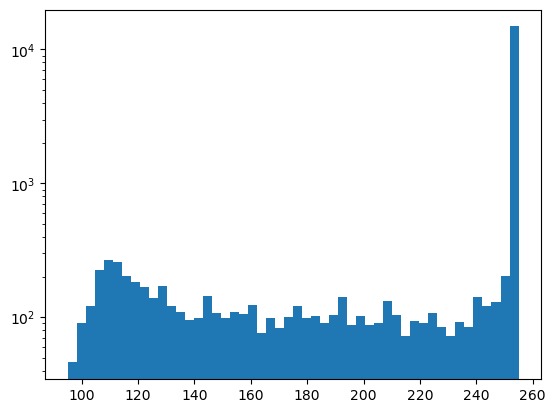

In [24]:
# plt.hist(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]).ravel(), bins=50)
plt.hist(bacteria_filtered_hsv[y:y + h, x:x + w,2].ravel(), bins=50)
plt.yscale('log')

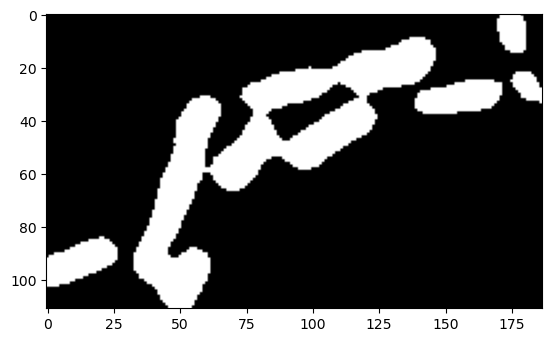

In [25]:
plt.figure()
plt.imshow(cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1],cmap='gray')
plt.show()

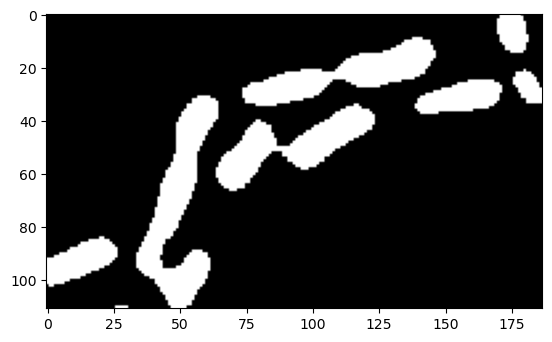

In [26]:
plt.figure()
plt.imshow(cv2.adaptiveThreshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),
                                 160,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, -20),cmap='gray')
plt.show()

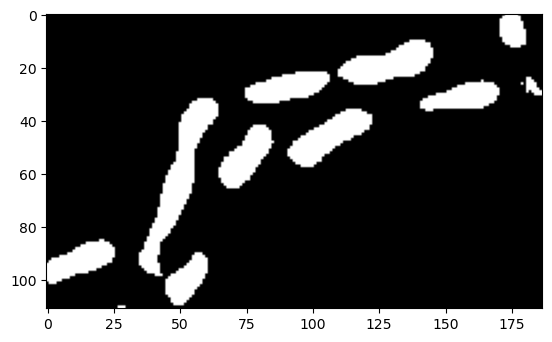

In [27]:
plt.figure()
plt.imshow(cv2.adaptiveThreshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),
                                 160,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, -40),cmap='gray')
plt.show()

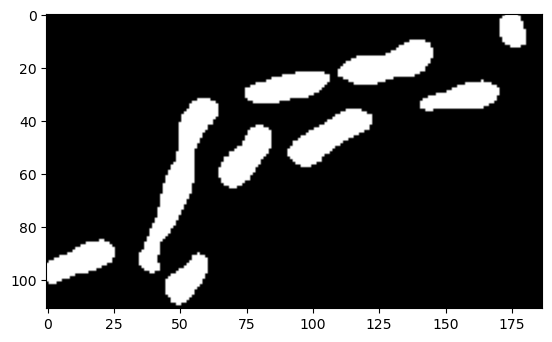

In [28]:
plt.figure()
plt.imshow(morph_op(cv2.adaptiveThreshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),
                                 160,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, -40),
                                 mode = 'open', ksize = 5, iterations = 1),cmap='gray')
plt.show()

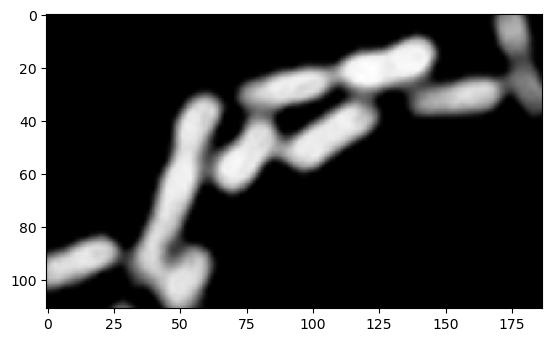

In [29]:
plt.figure()
plt.imshow(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),cmap='gray', vmin=0)
plt.show()

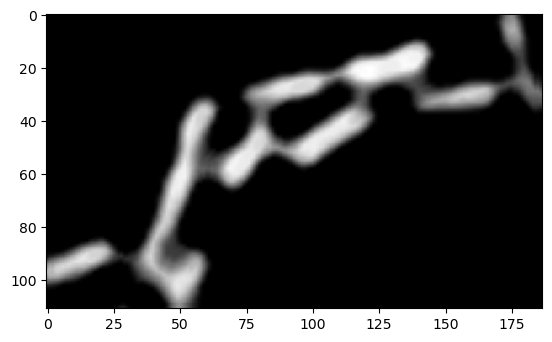

In [30]:
plt.figure()
plt.imshow(morph_op(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),
                     mode = 'erode', ksize = 5, iterations = 1),cmap='gray', vmin=0)
plt.show()

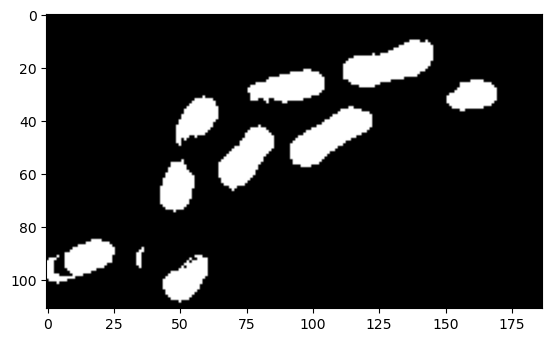

In [31]:
plt.figure()
plt.imshow(cv2.adaptiveThreshold(morph_op(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), 
                    mode = 'open', ksize = 11, iterations = 1),
                    160,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 23, -35),
                    cmap='gray')

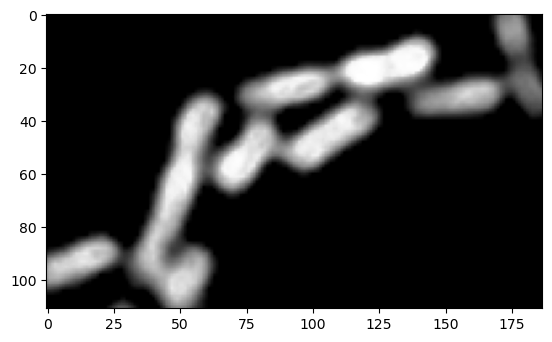

In [32]:
plt.figure()
plt.imshow(cv2.equalizeHist(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2])),cmap='gray', vmin=0, vmax=255)
plt.show()

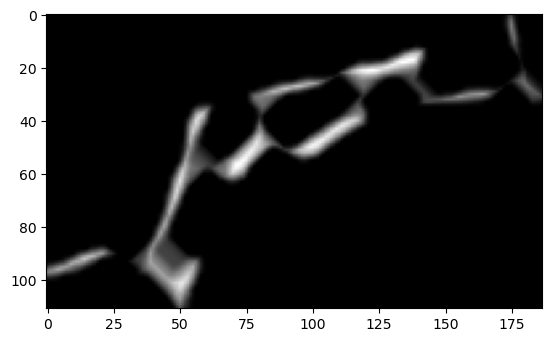

In [33]:
plt.figure()
plt.imshow(morph_op(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),
                     mode = 'erode', ksize = 3, iterations = 5),cmap='gray', vmin=0)
plt.show()

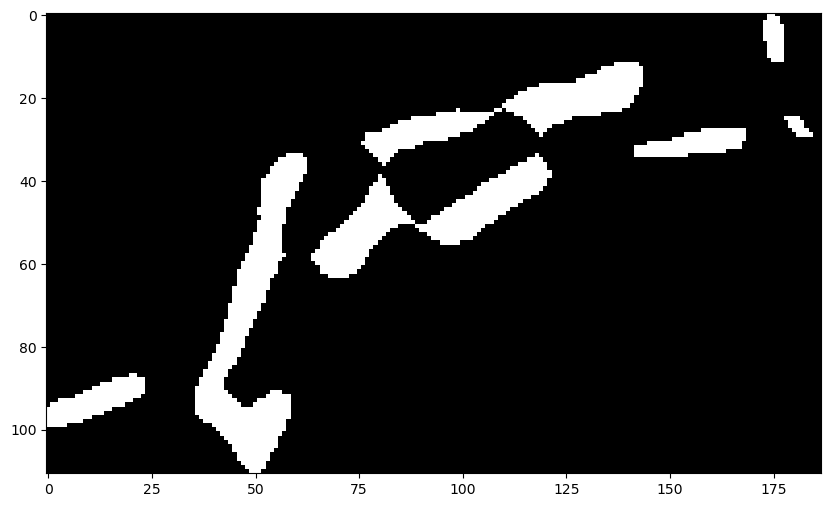

In [34]:
plt.figure(figsize=(10,8))
plt.imshow(morph_op(cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1],
                    mode = 'erode', ksize = 3, iterations = 3),cmap='gray')
plt.show()

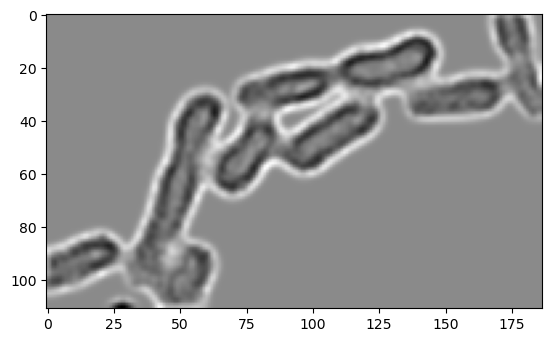

In [35]:
plt.figure()
plt.imshow(cv2.Laplacian(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), ddepth = cv2.CV_16S, ksize=7),cmap='gray')
plt.show()

In [36]:
from skimage.filters import sobel

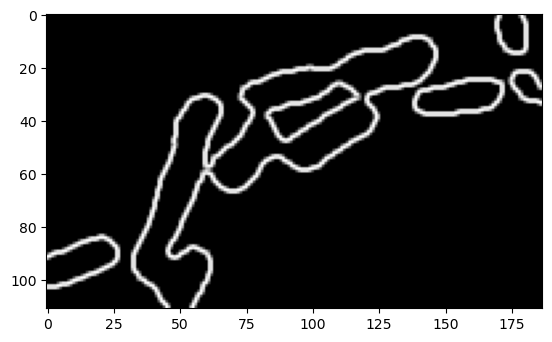

In [37]:
plt.figure()
plt.imshow(sobel(cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1]),cmap='gray')
plt.show()

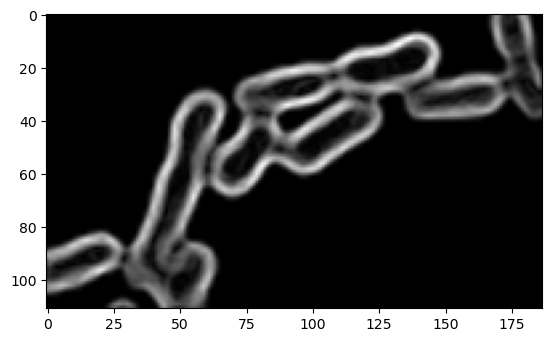

In [38]:
plt.figure()
plt.imshow(sobel(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2])),cmap='gray')
plt.show()

In [39]:
from skimage.segmentation import watershed, mark_boundaries, felzenszwalb, quickshift, slic

In [40]:
bacteria_filtered_hsv_largest_patch = slic(bacteria_filtered[y:y + h, x:x + w,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


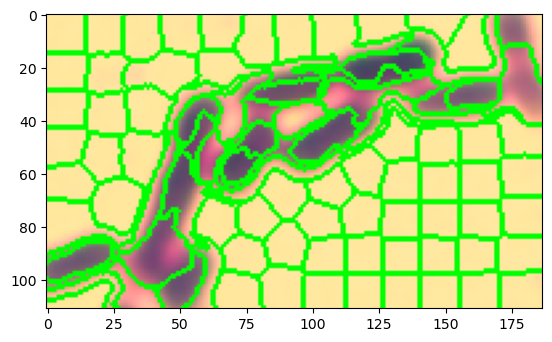

In [41]:
plt.imshow(mark_boundaries(cv2.cvtColor(bacteria_filtered[y:y + h, x:x + w], cv2.COLOR_BGR2RGB), bacteria_filtered_hsv_largest_patch, color=(0, 255, 0)))
plt.show()

In [42]:
bacteria_filtered_hsv_largest_patch = watershed(sobel(cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1]))

In [43]:
bacteria_filtered_hsv_largest_patch

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [44]:
image = cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1]
distance = sp.ndimage.distance_transform_edt(image)
coords = skimage.feature.peak_local_max(distance, min_distance=10, labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = sp.ndimage.label(mask)
labels = watershed(-distance, markers, mask=image)

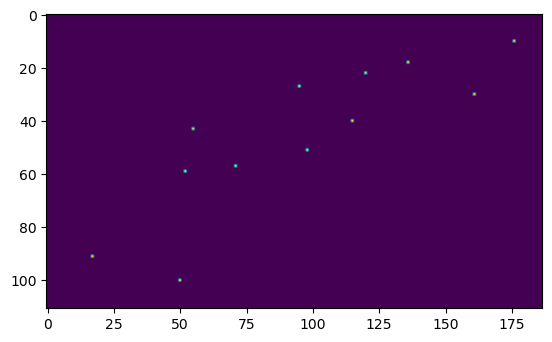

In [45]:
plt.imshow(mask)

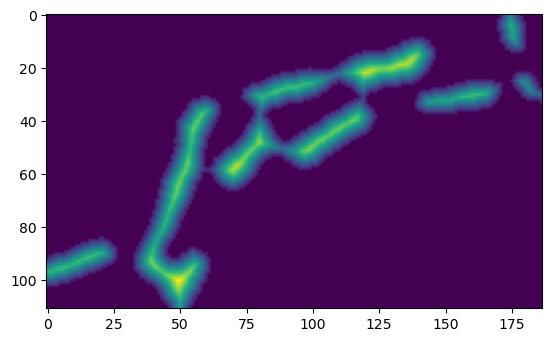

In [46]:
plt.imshow(distance)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


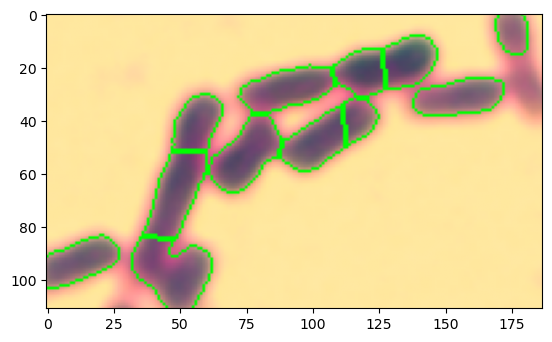

In [47]:
plt.imshow(mark_boundaries(cv2.cvtColor(bacteria_filtered[y:y + h, x:x + w], cv2.COLOR_BGR2RGB), labels, color=(0, 255, 0)))
plt.show()

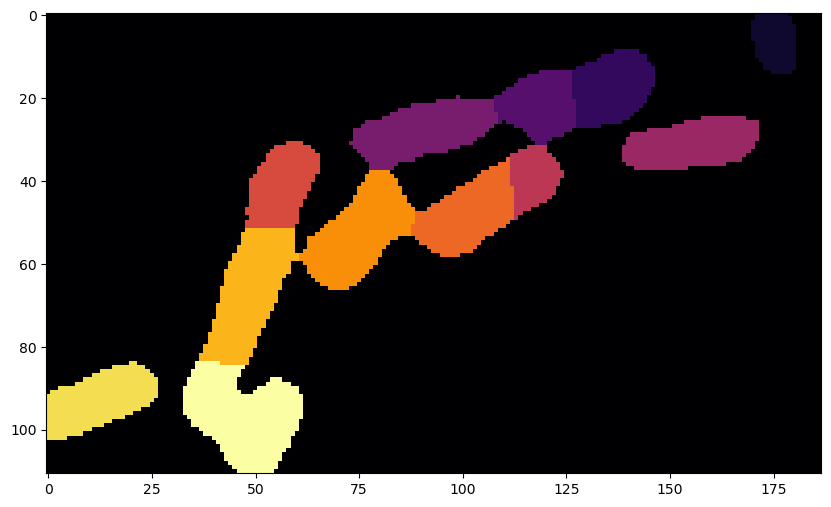

In [48]:
plt.figure(figsize=(10,6))
plt.imshow(labels, cmap='inferno')

In [49]:
np.where(cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1])

(array([  0,   0,   0, ..., 110, 110, 110], dtype=int64),
 array([171, 172, 173, ...,  52,  53,  54], dtype=int64))

In [50]:
bacteria_coords = np.where(cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1])

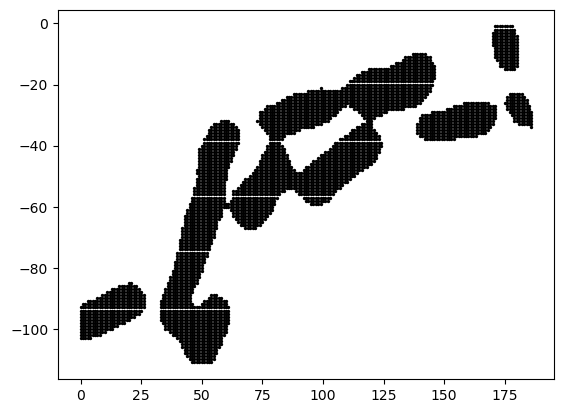

In [51]:
plt.scatter(bacteria_coords[1], np.invert(bacteria_coords[0]), s=2, c='black')

In [52]:
bacteria_proper_coords = np.array([[coord1, coord2] for coord1, coord2 in zip(bacteria_coords[1], np.invert(bacteria_coords[0]))])
bacteria_proper_coords

array([[ 171,   -1],
       [ 172,   -1],
       [ 173,   -1],
       ...,
       [  52, -111],
       [  53, -111],
       [  54, -111]], dtype=int64)

In [53]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, KMeans

In [54]:
# means_init = np.array([skimage.feature.peak_local_max(distance, min_distance=5, labels=image, num_peaks=10).T[1], 
#           np.invert(skimage.feature.peak_local_max(distance, min_distance=5, labels=image, num_peaks=10).T[0])]).T

In [55]:
gm = GaussianMixture(n_components=10, random_state=0)

In [56]:
bacteria_labels = gm.fit_predict(bacteria_proper_coords)
bacteria_labels

array([7, 7, 7, ..., 2, 2, 2], dtype=int64)

In [57]:
bacteria_proper_coords_labels = np.concatenate((bacteria_proper_coords.T, bacteria_labels.reshape(1,-1)), axis = 0)
bacteria_proper_coords_labels

array([[ 171,  172,  173, ...,   52,   53,   54],
       [  -1,   -1,   -1, ..., -111, -111, -111],
       [   7,    7,    7, ...,    2,    2,    2]], dtype=int64)

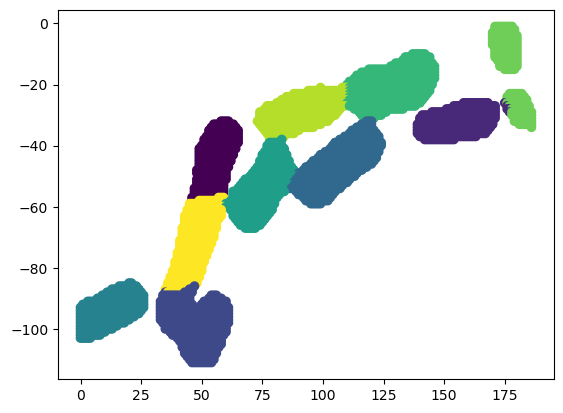

In [58]:
plt.scatter(bacteria_proper_coords_labels[0], bacteria_proper_coords_labels[1], c=bacteria_proper_coords_labels[2])

## One of the most successfull attempts to use watershed

In [59]:
image = cv2.adaptiveThreshold(morph_op(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), 
                    mode = 'open', ksize = 5, iterations = 1),
                    160,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 23, -35)
distance = sp.ndimage.distance_transform_edt(image)
coords = skimage.feature.peak_local_max(distance, min_distance=0, labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = sp.ndimage.label(mask)
labels = watershed(-distance, markers, mask=cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1])

C:\Users\egork\AppData\Local\Temp\ipykernel_5592\2795431050.py:5: RuntimeWarning: When min_distance < 1, peak_local_max acts as finding image > max(threshold_abs, threshold_rel * max(image)).
  coords = skimage.feature.peak_local_max(distance, min_distance=0, labels=image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


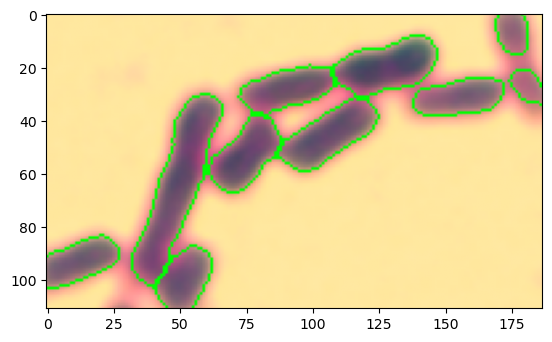

In [60]:
plt.imshow(mark_boundaries(cv2.cvtColor(bacteria_filtered[y:y + h, x:x + w], cv2.COLOR_BGR2RGB), labels, color=(0, 255, 0)))
plt.show()

## Hessian matrix idea

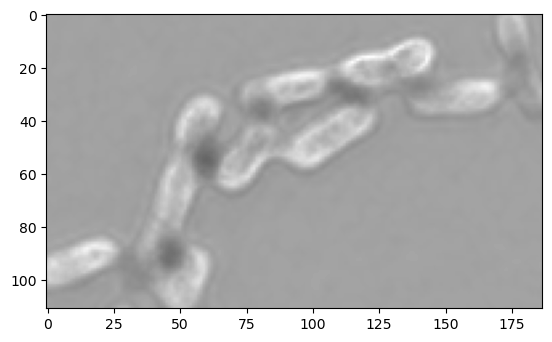

In [61]:
plt.figure()
plt.imshow(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,1]),cmap='gray', vmin=0)
plt.show()

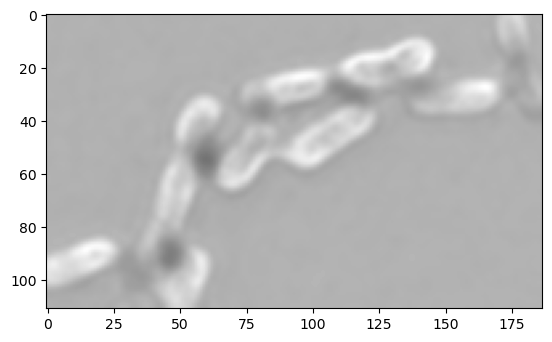

In [62]:
plt.figure()
plt.imshow(cv2.GaussianBlur(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,1]), (5,5), 0), cmap='gray', vmin=0)
plt.show()

In [63]:
def detect_ridges(gray, sigma=3.0):
    i1, i2 = skimage.feature.hessian_matrix_eigvals(skimage.feature.hessian_matrix(gray, sigma, use_gaussian_derivatives=True))
    return i1, i2

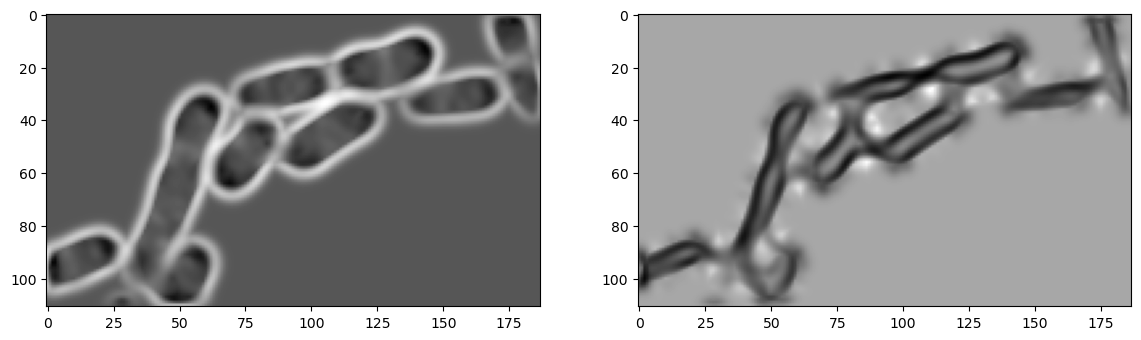

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].imshow(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[0], cmap='gray')
ax[1].imshow(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[1], cmap='gray')
plt.show()

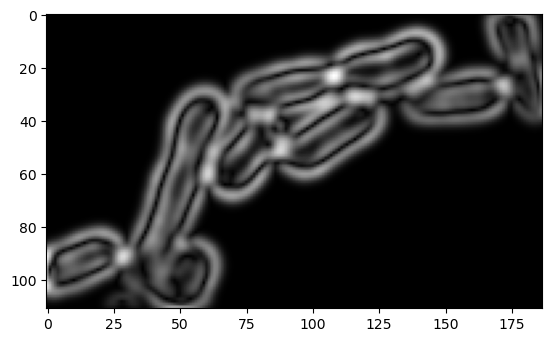

In [65]:
plt.figure()
plt.imshow(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[0] -\
           detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[1], cmap='gray')
plt.show()

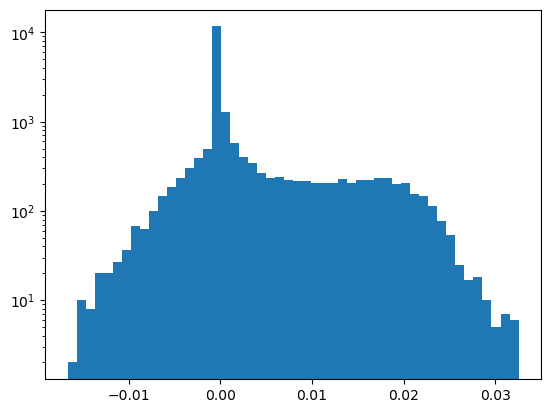

In [66]:
plt.hist(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[0].ravel(), bins=50)
plt.yscale('log')

In [67]:
sp.stats.mode(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]))[0].ravel())

ModeResult(mode=0.0, count=2467)

In [68]:
np.mean(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[0].ravel())

0.0026667754339018664

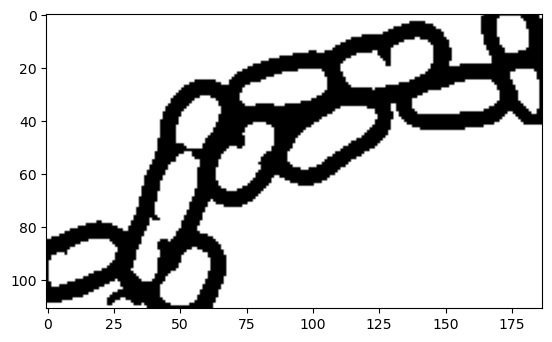

In [69]:
plt.figure()
plt.imshow(cv2.threshold(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),sigma=2)[0], 0.003, 1,cv2.THRESH_BINARY_INV)[1],cmap='gray')
plt.show()

In [70]:
cv2.threshold(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]))[0], 0.003, 1,cv2.THRESH_BINARY_INV)[1].astype(int)

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [71]:
cv2.threshold(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]))[0], 0.003, 1,cv2.THRESH_BINARY_INV)[1].astype(int).max()

1

In [72]:
image = cv2.threshold(detect_ridges(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]), sigma=2)[0],
                        0.003,
                        1,cv2.THRESH_BINARY_INV)[1].astype(int)
distance = sp.ndimage.distance_transform_edt(image)
coords = skimage.feature.peak_local_max(distance, min_distance=0, labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = sp.ndimage.label(mask)
labels = watershed(-distance, markers, mask=cv2.threshold(skimage.util.invert(bacteria_filtered_hsv[y:y + h, x:x + w,2]),60,160,cv2.THRESH_BINARY)[1])

C:\Users\egork\AppData\Local\Temp\ipykernel_5592\3751829505.py:5: RuntimeWarning: When min_distance < 1, peak_local_max acts as finding image > max(threshold_abs, threshold_rel * max(image)).
  coords = skimage.feature.peak_local_max(distance, min_distance=0, labels=image)


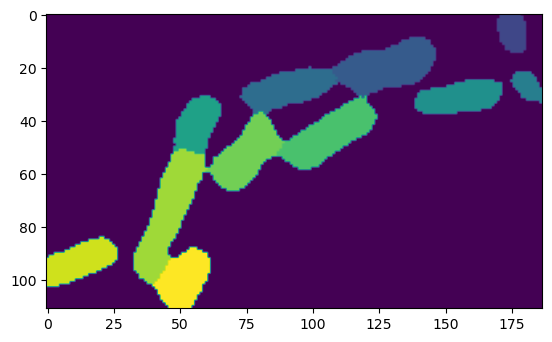

In [73]:
plt.imshow(labels)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


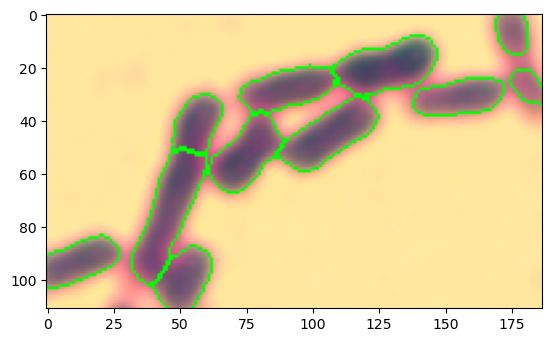

In [74]:
plt.imshow(mark_boundaries(bacteria_filtered[y:y + h, x:x + w,::-1], labels, color=(0, 255, 0)))
plt.show()

# Importing BFmainlib

In [94]:
import sys
sys.path.append('../')
from scripts.BFmainlib import BF_image, HSV_threshold, HSV_transform

In [95]:
image_paths = [f'../pictures/test_input_{i}.bmp' for i in range(1, 6)]

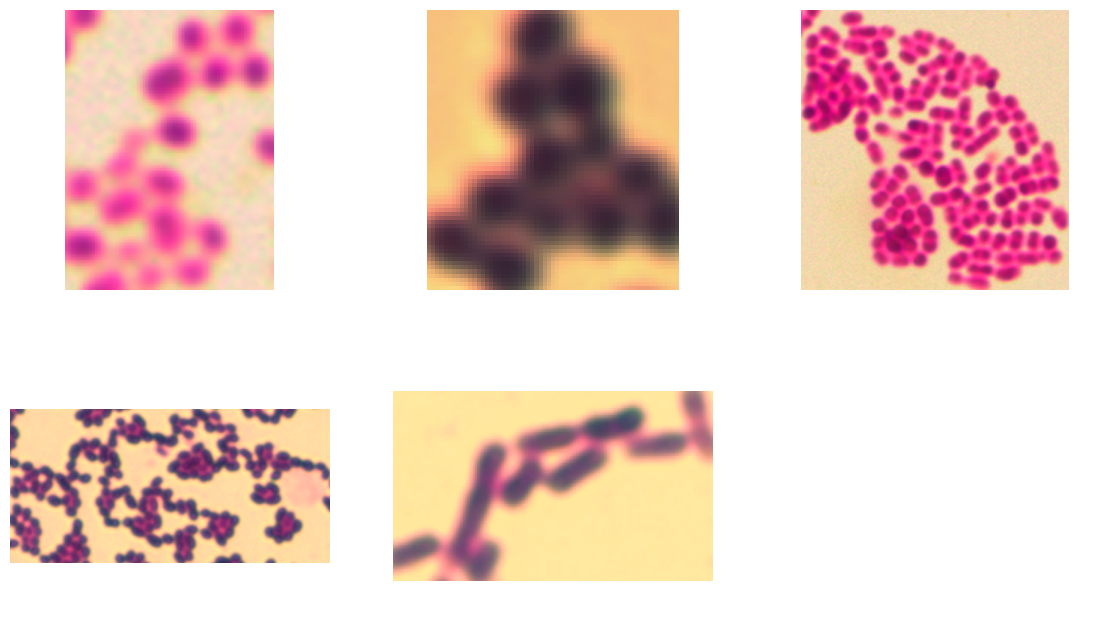

In [103]:
fig, axs = plt.subplots(2,3, figsize=(14,8))
for i in range(5):
    test_image_class = BF_image(verbose=False)
    test_image_class.load_image(image_paths[i])
    test_image_class.preprocess_image()
    test_image_class.segment_image()
    x, y, w, h = cv2.boundingRect(test_image_class.objects_db['2'].object_countour_coords)
    axs[i//3][i%3].imshow(test_image_class.bacteria_image_preprocessed[y:y + h, x:x + w])
    axs[i//3][i%3].axis('off')

axs[1][2].axis('off')
plt.show()

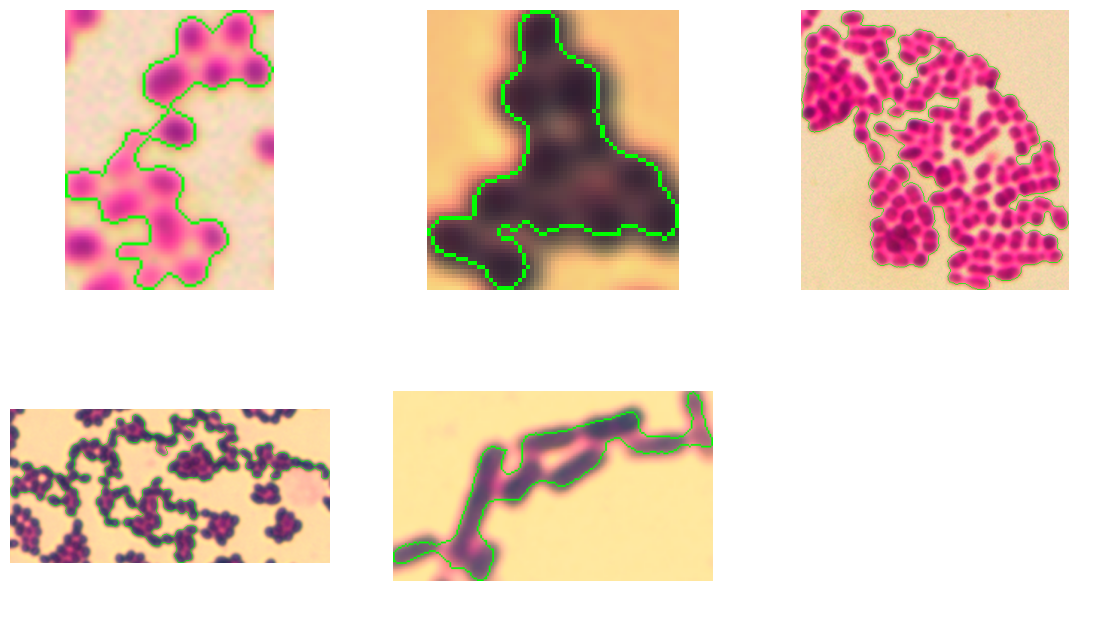

In [104]:
fig, axs = plt.subplots(2,3, figsize=(14,8))
for i in range(5):
    test_image_class = BF_image(verbose=False)
    test_image_class.load_image(image_paths[i])
    test_image_class.preprocess_image()
    test_image_class.segment_image()
    x, y, w, h = cv2.boundingRect(test_image_class.objects_db['2'].object_countour_coords)
    axs[i//3][i%3].imshow(test_image_class.object_draw(test_image_class.objects_db['2'].object_countour_coords)[y:y + h, x:x + w])
    axs[i//3][i%3].axis('off')

axs[1][2].axis('off')
plt.show()

## HUE inspection

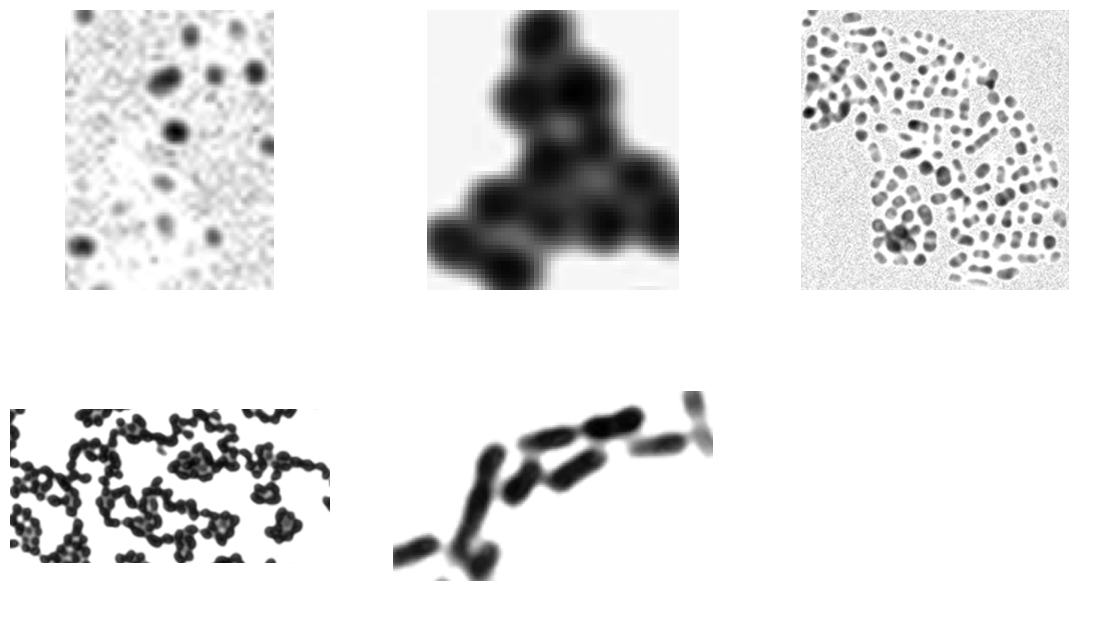

In [105]:
fig, axs = plt.subplots(2,3, figsize=(14,8))
for i in range(5):
    test_image_class = BF_image(verbose=False)
    test_image_class.load_image(image_paths[i])
    test_image_class.preprocess_image()
    test_image_class.segment_image()
    x, y, w, h = cv2.boundingRect(test_image_class.objects_db['2'].object_countour_coords)
    axs[i//3][i%3].imshow(HSV_transform(test_image_class.bacteria_image_preprocessed)[y:y + h, x:x + w,2], cmap='gray')
    axs[i//3][i%3].axis('off')

axs[1][2].axis('off')
plt.show()

In [106]:
def detect_ridges(gray, sigma=2.0):
    i1, i2 = skimage.feature.hessian_matrix_eigvals(skimage.feature.hessian_matrix(gray, sigma, use_gaussian_derivatives=True))
    return i1, i2

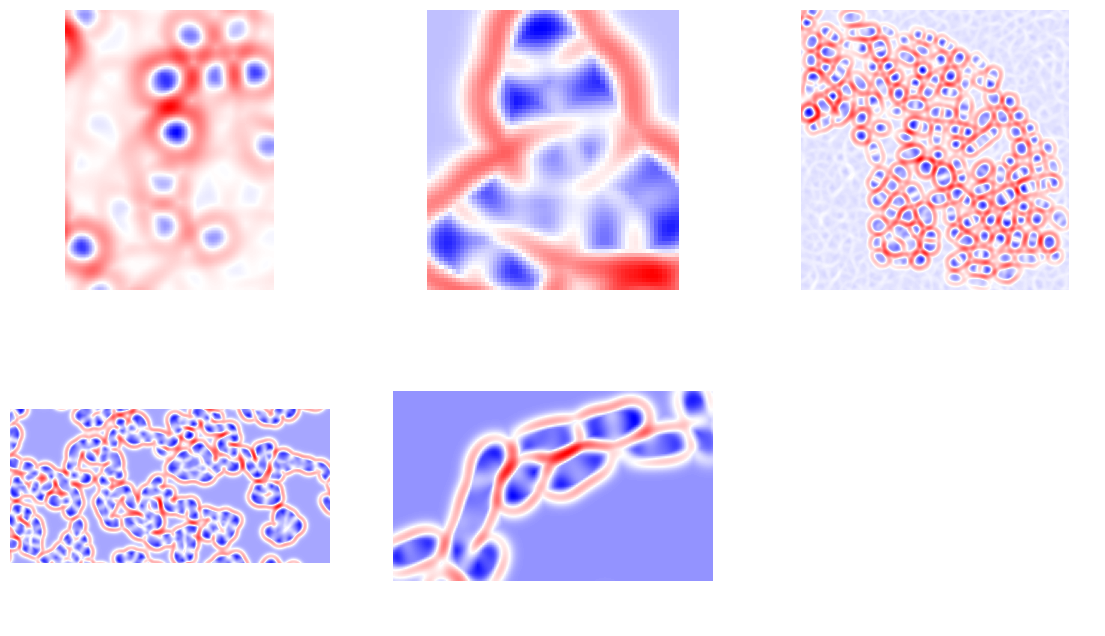

In [113]:
fig, axs = plt.subplots(2,3, figsize=(14,8))
for i in range(5):
    test_image_class = BF_image(verbose=False)
    test_image_class.load_image(image_paths[i])
    test_image_class.preprocess_image()
    test_image_class.segment_image()
    x, y, w, h = cv2.boundingRect(test_image_class.objects_db['2'].object_countour_coords)
    axs[i//3][i%3].imshow(detect_ridges(skimage.util.invert(HSV_transform(test_image_class.bacteria_image_preprocessed)[:,:,2]), sigma=4)[0][y:y + h, x:x + w], cmap='bwr')
    axs[i//3][i%3].axis('off')

axs[1][2].axis('off')
plt.show()